In [117]:
from qiskit import *

import torch
import torch.nn as nn

# Import from Qiskit Aer noise module
from qiskit.providers.aer import AerSimulator

import numpy as np

%matplotlib inline
%matplotlib inline

In [118]:
# nqubits = 3**2

backend = AerSimulator()

[(22, 15), (29, 27), (7, 3)]


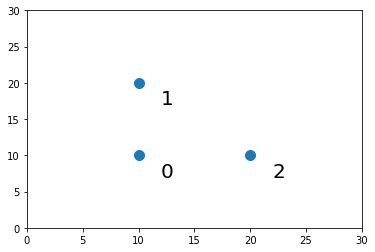

In [119]:
import random
import matplotlib.pyplot as plt
import math

# city_number = int(nqubits**0.5)
map_x = 30
map_y = 30

# def create_city(map_x, map_y):
#     x0 = random.randint(0, map_x)
#     y0 = random.randint(0, map_y)
#     return x0, y0


# def create_map(city_number, map_x, map_y):
#     city_list = []
#     for i in range(city_number):
#         while True: 
#             this_city = create_city(map_x, map_y)
#             if this_city in city_list:
#                 continue
#             else:
#                 city_list.append(this_city)
#                 break
                
#     return city_list

# my_map = create_map(city_number, map_x, map_y)
# print(my_map)


def plot_map(my_map, my_path=None):
    xs = [x[0] for x in my_map]
    ys = [x[1] for x in my_map]
    plt.scatter(xs, ys, s=100)
    plt.xlim(0, map_x)
    plt.ylim(0, map_y)
#     plt.figure(figsize=(5,5))
    for i in range(len(my_map)):
        plt.text(xs[i]+2, ys[i]-3, i, fontsize = 20)
    
    if my_path:
        for i in range(len(my_path)-1):
            plt.plot([my_map[my_path[i]][0], my_map[my_path[i+1]][0]], [my_map[my_path[i]][1], my_map[my_path[i+1]][1]], 'ro-')
    plt.show()

# my_path = None
# my_path = [0, 1, 2, 3, 0]
# my_map = [(10, 10), (10, 20), (22, 20)]
my_map = [(10, 10), (10, 20), (20, 10)]
plot_map(my_map)


def dist(p, q):
    return math.sqrt((float(p[0]) - float(q[0])) ** 2 + (float(p[1]) - float(q[1])) ** 2)

def to_distance_matrix(my_map):
    ret = []
    for i in range(len(my_map)):
        this_line = []
        for j in range(len(my_map)):
            this_line.append(dist(my_map[i], my_map[j]))
        ret.append(this_line)
            
    return ret

distance_matrix = to_distance_matrix(my_map)

[0, 2, 1, 0] 34.14213562373095


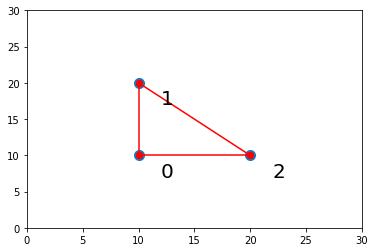

In [120]:
from sys import maxsize
from itertools import permutations
def brute_tsp(graph, s=0):
    vertex = []
    V = len(graph)
    for i in range(V):
        if i != s:
            vertex.append(i)

    min_path = maxsize
    next_permutation=permutations(vertex)
    for i in next_permutation:
        current_pathweight = 0
        k = s
        for j in i:
            current_pathweight += graph[k][j]
            k = j
        current_pathweight += graph[k][s]
        min_path = min(min_path, current_pathweight)
        if min_path == current_pathweight:
            ret_path = list(i)
    ret_path = [0] + ret_path + [0]
    return ret_path, min_path

s = 0
min_path, min_distance = brute_tsp(distance_matrix, s)
print(min_path, min_distance)

plot_map(my_map, min_path)

000000000      31768.591949959053
000000001      -3586.7471093683243
000000010      -3586.7471093683225
000000011      -10657.814921233803
000000100      -3586.747109368326
000000101      -10657.814921233807
000000110      -10657.814921233807
000000111      10555.388514362625
000001000      -3586.747109368327
000001001      -10657.814921233807
000001010      -38927.94403307198
000001011      -17714.740597475553
000001100      -38927.94403307198
000001101      -17714.740597475553
000001110      -45984.86970931373
000001111      3512.6049737446
000010000      -3586.7471093683253
000010001      -38927.94403307198
000010010      -10657.814921233805
000010011      -17714.740597475553
000010100      -38927.94403307198
000010101      -45984.86970931373
000010110      -17714.740597475553
000010111      3512.604973744598
000011000      -10657.814921233803
000011001      -17714.740597475553
000011010      -17714.740597475553
000011011      3512.6049737445996
000011100      -45984.86970931373
000

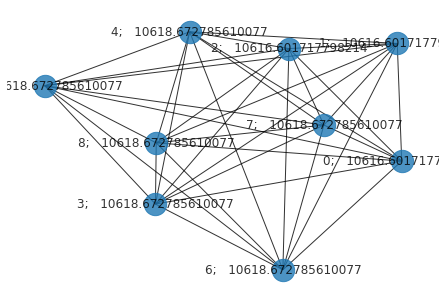

In [121]:
import networkx as nx
from itertools import combinations


def tsp_matrix_to_QUBO_matrix(w, penality=1000):
    n = len(w)
    Q = np.zeros((n*n, n*n))
    c = np.ones(n*n)
    A = np.max(w) * penality # penality
    c = c * (-4*A)

    # k, l is the index of Q
    # i, j, p, p_ is the index of w
    for k in range(n*n):
        for l in range(n*n):
            i = k // n
            j = l // n
            p = k % n 
            p_ = l % n 
            if  (p+1)%n == p_ and i != j:
                Q[k, l] = w[i, j] 
            elif p == p_:
                Q[k, l] = Q[k, l] + A
            elif i == j:
                Q[k, l] = Q[k, l] + A

    return Q, c

def QUBO_to_Ising(Q, c):
    J = Q/4
    h = (c + np.sum(Q, axis=1))/2

    for i in range(len(h)):
        J[i][i] += h[i]

    return J


distance_matrix = np.array(distance_matrix)
Q, c = tsp_matrix_to_QUBO_matrix(distance_matrix)

Ising_coeff = QUBO_to_Ising(Q, c)
Ising_coeff = Ising_coeff.tolist()


# Visualize the connectivity of the Ising model
G = nx.Graph()
pairs = []
for i in range(0, nqubits):
    G.add_node(i, weight = Ising_coeff[i][i])
    for j in range(i+1, nqubits):
        pairs.append((i, j, Ising_coeff[i][j]))
G.add_weighted_edges_from(pairs)
labels = {n: str(n) + ';   ' + str(G.nodes[n]['weight']) for n in G.nodes}
nx.draw(G, with_labels=True, labels=labels, alpha=0.8, node_size=500)


# @jit(nopython=True, parallel=True, fastmath=True)
def H_Ising(bitstring, Ising_coeff):
    spins = []
    for bit in bitstring:
        if bit == '0':
            spins.append(-1)
        elif bit == '1':
            spins.append(1)
    H = 0
    for i in range(0, nqubits):
        H += Ising_coeff[i][i]*spins[i]
        for j in range(nqubits):
            if i != j:
                H += Ising_coeff[i][j]*spins[i]*spins[j]
    return H


H_min = 10000
for i in range(2**len(Ising_coeff)):
    bitstring = np.binary_repr(i, nqubits)
    print(bitstring, "    ", H_Ising(bitstring, Ising_coeff))
    if H_Ising(bitstring, Ising_coeff) < H_min:
        H_min = H_Ising(bitstring, Ising_coeff)
        config_min = bitstring
print('The minimum value of the Hamiltonian:', H_min, 'the configuration:', config_min)

In [122]:


def compute_expectation(counts, Ising_coeff):   
    """
    Computes expectation value based on measurement results
    """   
    sum = 0
    sum_count = 0
    for bitstring, count in counts.items():
        sum += count*H_Ising(bitstring, Ising_coeff)
        sum_count += count
    return sum/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(Ising_coeff, theta): 
    """
    Creates a parametrized qaoa circuit
    """   
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(nqubits):
            for j in range(i+1, nqubits):
                if Ising_coeff != 0:
                    qc.rzz(2 * Ising_coeff[i][j]*gamma[irep], i, j)
        # mixer unitary
        for i in range(nqubits):
            qc.rz(2 * Ising_coeff[i][i]*gamma[irep], i)
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(theta):
    """
    Runs parametrized circuit and get expectation value
    
    """
    qc = create_qaoa_circ(Ising_coeff, theta)       
    qc = transpile(qc, backend=backend)
    if seed:
        seed_simulator = 10
    else:
        seed_simulator = None
    counts = backend.run(qc, seed_simulator=seed_simulator, nshots=shots).result().get_counts()       

    return compute_expectation(counts, Ising_coeff)

In [123]:
circuit = create_qaoa_circ(Ising_coeff, [1, 1])
# circuit = transpile(circuit, backend=backend)
circuit.draw()

┌───┐                                                            »
   q_0: ┤ H ├─■────────────■────────────■─────────────────────────■──────»
        ├───┤ │ZZ(7071.1)  │            │                         │      »
   q_1: ┤ H ├─■────────────┼────────────┼────────────■────────────┼──────»
        ├───┤              │ZZ(7071.1)  │            │ZZ(7071.1)  │      »
   q_2: ┤ H ├──────────────■────────────┼────────────■────────────┼──────»
        ├───┤                           │ZZ(7071.1)               │      »
   q_3: ┤ H ├───────────────────────────■─────────────────────────┼──────»
        ├───┤                                                     │ZZ(5) »
   q_4: ┤ H ├─────────────────────────────────────────────────────■──────»
        ├───┤                                                            »
   q_5: ┤ H ├────────────────────────────────────────────────────────────»
        ├───┤                                                            »
   q_6: ┤ H ├────────────────────────────────────────────────────────────»
        ├───┤                                                            »
   q_7: ┤ H ├────────────────────────────────────────────────────────────»
        ├───┤                                                            »
   q_8: ┤ H ├────────────────────────────────────────────────────────────»
        └───┘                                                            »
meas: 9/═════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                          »
«   q_0: ─────────■────────────────────────────■───────────────────────────»
«                 │                            │                           »
«   q_1: ─■───────┼───────■────────────────────┼────────────■──────────────»
«         │       │       │                    │            │              »
«   q_2: ─┼───────┼───────┼────────────■───────┼────────────┼───────■──────»
«         │ZZ(0)  │       │            │ZZ(5)  │            │       │      »
«   q_3: ─■───────┼───────┼────────────■───────┼────────────┼───────┼──────»
«                 │       │ZZ(7071.1)          │            │       │ZZ(0) »
«   q_4: ─────────┼───────■────────────────────┼────────────┼───────■──────»
«                 │ZZ(0)                       │            │ZZ(5)         »
«   q_5: ─────────■────────────────────────────┼────────────■──────────────»
«                                              │ZZ(7071.1)                 »
«   q_6: ──────────────────────────────────────■───────────────────────────»
«                                                                          »
«   q_7: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«   q_8: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«meas: 9/══════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                          ┌───────────┐»
«   q_0: ─■─────────────────────────────────────────■──────┤ Rz(21233) ├»
«         │                                         │      └───────────┘»
«   q_1: ─┼───────■─────────────────────────────────┼───────■───────────»
«         │       │                                 │       │           »
«   q_2: ─┼───────┼───────■─────────────────────────┼───────┼───────────»
«         │       │       │                         │       │           »
«   q_3: ─┼───────┼───────┼────────────■────────────┼───────┼───────────»
«         │       │       │            │ZZ(7071.1)  │       │           »
«   q_4: ─┼───────┼───────┼────────────■────────────┼───────┼───────────»
«         │       │       │ZZ(7071.1)               │       │           »
« 

In [124]:
# def optimizer(eps, theta, lr, momentum):
#     grad = [0 for t in range(len(theta))]
#     for i in range(len(theta)):
#         # Uses a symmetric difference to calulate the gradient
#         theta[i] += eps
#         grad[i] = get_expectation(theta)
#         theta[i] -= 2*eps
#         grad[i] -= get_expectation(theta)
#         grad[i] /= 2*eps
#         theta[i] += eps      
#         # Update the parameters by gradient descent with momentum
#         v[i] = momentum*v[i] - lr*grad[i]
#         theta[i] = theta[i] + v[i]

#     return theta

In [125]:
# seed = True
# shots = 1024
# eps = 10**-6
# p = 2
# lr = 100
# momentum = 0.0
# num_steps = 30
# schedule = [25]
# lr_decay = 0.1


# # Initialize the parameters
# torch.manual_seed(0)
# theta = torch.empty(int(2*p))
# torch.nn.init.normal_(theta, mean=0.5, std=0.01)
# theta = theta.tolist()


# expectation_list = []
# theta_list = []
# # Perform SGD with momentum
# v = [0 for i in range(int(2*p))]
# for i in range(num_steps + 1):      # Update the parameters
#     expectation = get_expectation(theta)
#     expectation_list.append(expectation)
#     if i in schedule:      # Learning rate scheduling (step)
#         lr = lr*lr_decay
#     theta = optimizer(eps, theta, lr, momentum)
#     if (i != 0) and (i % 10 == 0):
#         theta_list.append(theta)
#     print('The expectation values at iteration =', i, 'is:', expectation, )

The expectation values at iteration = 0 is: 379.82563518748896
The expectation values at iteration = 1 is: 2033.9174411867573
The expectation values at iteration = 2 is: 4475.572594488419
The expectation values at iteration = 3 is: 4475.572594488419
The expectation values at iteration = 4 is: 4475.572594488419
The expectation values at iteration = 5 is: 4475.572594488419
The expectation values at iteration = 6 is: 4475.572594488419
The expectation values at iteration = 7 is: 4475.572594488419
The expectation values at iteration = 8 is: 4475.572594488419
The expectation values at iteration = 9 is: 4475.572594488419
The expectation values at iteration = 10 is: 4475.572594488419
The expectation values at iteration = 11 is: 4475.572594488419
The expectation values at iteration = 12 is: 4475.572594488419
The expectation values at iteration = 13 is: 4475.572594488419
The expectation values at iteration = 14 is: 4475.572594488419
The expectation values at iteration = 15 is: 4475.572594488419


In [126]:
Ising_coeff

[[10616.601717798214,
  3535.533905932738,
  3535.533905932738,
  3535.533905932738,
  2.5,
  0.0,
  3535.533905932738,
  2.5,
  0.0],
 [3535.533905932738,
  10616.601717798214,
  3535.533905932738,
  0.0,
  3535.533905932738,
  2.5,
  0.0,
  3535.533905932738,
  2.5],
 [3535.533905932738,
  3535.533905932738,
  10616.601717798214,
  2.5,
  0.0,
  3535.533905932738,
  2.5,
  0.0,
  3535.533905932738],
 [3535.533905932738,
  2.5,
  0.0,
  10618.672785610077,
  3535.533905932738,
  3535.533905932738,
  3535.533905932738,
  3.5355339059327378,
  0.0],
 [0.0,
  3535.533905932738,
  2.5,
  3535.533905932738,
  10618.672785610077,
  3535.533905932738,
  0.0,
  3535.533905932738,
  3.5355339059327378],
 [2.5,
  0.0,
  3535.533905932738,
  3535.533905932738,
  3535.533905932738,
  10618.672785610077,
  3.5355339059327378,
  0.0,
  3535.533905932738],
 [3535.533905932738,
  2.5,
  0.0,
  3535.533905932738,
  3.5355339059327378,
  0.0,
  10618.672785610077,
  3535.533905932738,
  3535.5339059327

In [127]:
"""
seed = True
shots = 1024
eps = 10**-3
momentum = 0.0
num_steps = 100
schedule = [60]
lr_decay = 0.1

p_list = [int(i+1) for i in range(10)]
lr_list = [0.5*10**-2, 1*10**-2, 2*10**-2, 5*10**-2, 10*10**-2, 20*10**-2, 50*10**-2]

p_list = [2]
lr_list = [0.01]


minimum_list = []
lr_best_list = []
theta_best_list = []
for num_p in p_list:
    p = num_p
    print('\nFor p =', p, ':')
    minimum = 1
    for lr in lr_list:
        # Initialize the parameters
        torch.manual_seed(0)
        theta = torch.empty(1, int(2*p))
        torch.nn.init.normal_(theta, mean=0.5, std=0.01)
        theta = theta.tolist()[0]
        # Perform SGD with momentum
        v = [0 for i in range(len(theta))]
        for i in range(num_steps + 1):      # Update the parameters
            if i in schedule:      # Learning rate scheduling (step)
                lr = lr*lr_decay
            theta = optimizer(eps, theta, lr, momentum)

        expectation = get_expectation(theta)
        if expectation < minimum:
            minimum = expectation
            lr_best = lr
            theta_best = theta

        print('Learning rate =', lr, 'the expectation value =', expectation)

    minimum_list.append(minimum)
    lr_best_list.append(lr_best)
    theta_best_list.append(theta_best)
    print('The min. expectation value = ', minimum, 'when learning rate =', lr_best)
    print('-----------------Temporary results-----------------')
    for i in range(len(minimum_list)): 
        print('The optimized parameters:',  theta_best_list[i])
    print('Min. expectaion value =', minimum_list)
    print('Best learning rate =', lr_best_list)
"""

"\nseed = True\nshots = 1024\neps = 10**-3\nmomentum = 0.0\nnum_steps = 100\nschedule = [60]\nlr_decay = 0.1\n\np_list = [int(i+1) for i in range(10)]\nlr_list = [0.5*10**-2, 1*10**-2, 2*10**-2, 5*10**-2, 10*10**-2, 20*10**-2, 50*10**-2]\n\np_list = [2]\nlr_list = [0.01]\n\n\nminimum_list = []\nlr_best_list = []\ntheta_best_list = []\nfor num_p in p_list:\n    p = num_p\n    print('\nFor p =', p, ':')\n    minimum = 1\n    for lr in lr_list:\n        # Initialize the parameters\n        torch.manual_seed(0)\n        theta = torch.empty(1, int(2*p))\n        torch.nn.init.normal_(theta, mean=0.5, std=0.01)\n        theta = theta.tolist()[0]\n        # Perform SGD with momentum\n        v = [0 for i in range(len(theta))]\n        for i in range(num_steps + 1):      # Update the parameters\n            if i in schedule:      # Learning rate scheduling (step)\n                lr = lr*lr_decay\n            theta = optimizer(eps, theta, lr, momentum)\n\n        expectation = get_expectation(

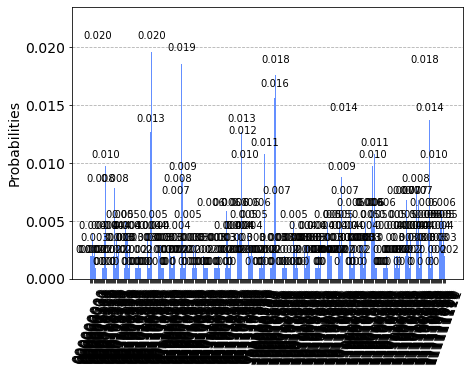

In [128]:
# from qiskit.visualization import plot_histogram

# qc_result = create_qaoa_circ(Ising_coeff, theta)
# counts = backend.run(qc_result).result().get_counts()

# plot_histogram(counts)

In [129]:
# print(counts)

{'011110000': 1, '001010011': 1, '011001101': 1, '110101111': 1, '010000010': 1, '101111111': 1, '010101110': 1, '101010110': 1, '100110011': 1, '010001111': 1, '111100000': 1, '001011001': 1, '111110111': 1, '001101000': 1, '100000110': 1, '101011000': 1, '010110101': 1, '100101000': 1, '101011001': 1, '010000011': 1, '100100011': 1, '011011011': 1, '011010001': 1, '000001100': 1, '101111100': 1, '001111111': 2, '011000111': 1, '100110101': 1, '010011010': 1, '111110100': 2, '000011011': 2, '100111111': 3, '100011101': 1, '000110100': 3, '110001011': 1, '001111100': 2, '000000001': 2, '110100011': 1, '101111001': 1, '101101101': 2, '110101101': 1, '011100101': 4, '101000111': 2, '110010001': 3, '000101001': 1, '100101001': 3, '011000011': 1, '001000011': 4, '001001100': 1, '000100100': 1, '101000001': 1, '111001100': 3, '011011000': 2, '010011000': 1, '101000100': 3, '100110111': 1, '001001111': 2, '101100111': 2, '001000110': 1, '000001011': 2, '011000001': 1, '110010010': 3, '100101